In [25]:
from src.model_helper import ModelHelper

CONFIG = "src/model/golf_mobilenetv2_256x192.py"
WEIGHT = "src/model/best.pth"
MODELWIDTH = 192
MODELHEIGHT = 256
DEVICE = "cuda:1"
modelHelper = ModelHelper(CONFIG,WEIGHT, modelWidth=MODELWIDTH, modelHeight=MODELHEIGHT, device=DEVICE)

import onnxruntime as ort
INPUTNAME = "images" # 1 3 640 640
ortSess = ort.InferenceSession("src/model/640s_full.onnx")

load checkpoint from local path: src/model/best.pth
function : __init__ | time : 0.3200


In [32]:
import cv2
import numpy as np
from src.img_handler import drawSkeleton, getSkeletons, addPadding
import torch, torchvision
def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

def box_area(box):
    # box = xyxy(4,n)
    return (box[2] - box[0]) * (box[3] - box[1])
    
def box_iou(box1, box2, eps=1e-7):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1[:, None].chunk(2, 2), box2.chunk(2, 1)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / (box_area(box1.T)[:, None] + box_area(box2.T) - inter + eps)

def non_max_suppression(prediction,
                        conf_thres=0.05,
                        iou_thres=0.45,
                        classes=None,
                        agnostic=False,
                        multi_label=False,
                        labels=(),
                        max_det=300):
    """Non-Maximum Suppression (NMS) on inference results to reject overlapping bounding boxes

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    bs = prediction.shape[0]  # batch size
    nc = prediction.shape[2] - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates
    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    max_wh = 7680  # (pixels) maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 0.3 + 0.03 * bs  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS
    
    output = [torch.zeros((0, 6), device=prediction.device)] * bs
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence
        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + 5), device=x.device)
            v[:, :4] = lb[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(lb)), lb[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)
        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]
        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]

    return output

def resizeWithLetterBox(inputImg, w, h):
    img = inputImg.copy()
    cropH, cropW = img.shape[:2]
    ratio = min(w/cropW, h/cropH)
    refineW, refineH = (int(x*ratio) for x in (cropW, cropH))
    dw = (w - refineW)/2
    dh = (h - refineH)/2
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.resize(img, (refineW, refineH), interpolation=cv2.INTER_LINEAR)
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114, 114, 114))
    return img, left, top, ratio

def refineOutput(output, leftPad, topPad, resizeRatio, x1, y1):
    output[:,0] = ((output[:,0] - leftPad) / resizeRatio)
    output[:,1] = ((output[:,1] - topPad) / resizeRatio)
    output[:,0] += x1
    output[:,1] += y1
    
    return output.numpy().tolist()


skeleton = getSkeletons()

In [46]:
VIDNAME = "7_h264"
cap = cv2.VideoCapture(f"input/{VIDNAME}.mp4")
frameSize =  [int(cap.get(x)) for x in [cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT]]
out = cv2.VideoWriter(f"output/{VIDNAME}_output.mp4", cv2.VideoWriter_fourcc(*"XVID"), 20.0, frameSize)
while(True):
  ok, frame = cap.read()
  if not ok:
    break
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
  img = frame.copy()
  img, left, top ,ratio = resizeWithLetterBox(img, 640, 640)
  img = cv2.resize(img, (640,640))
  img = np.transpose(img, (2,0,1)) # H W C -> C H W
  img = img / 255 # value range [0, 255] -> [0, 1]

  mean = np.array([0.485, 0.456, 0.406]).reshape([-1,1,1]) # (3, 1, 1)
  std = np.array([0.229, 0.224, 0.225]).reshape([-1,1,1]) # (3, 1, 1)

  img = np.subtract(img, mean)
  img = np.divide(img,std)
  img = img.astype(np.float32)
  img = np.expand_dims(img, axis=0)

  output = ortSess.run(None, {INPUTNAME : img})
  t = torch.tensor(output[0])

  # Bbox 추출하기
  nmsOutput = non_max_suppression(t)[0]
  outputs = [None, None]
  a = torch.tensor([])
  for output in nmsOutput:
    outputIdx = int(output[5])
    if outputs[outputIdx] is None:
      outputs[outputIdx] = output[:5]
    else:
      if output[4] > outputs[outputIdx][4]:
        outputs[outputIdx] = output[:5]
  
  nullCheck = True
  for o in outputs:
    if o is not None:
      nullCheck = False
  if nullCheck:
    continue
  outputs = np.stack([x for x in outputs if x is not None])
  outputs[:,0] = ((outputs[:,0] - left) / ratio) + 0
  outputs[:,1] = ((outputs[:,1] - top) / ratio) + 0
  outputs[:,2] = ((outputs[:,2] - left) / ratio) + 0
  outputs[:,3] = ((outputs[:,3] - top) / ratio) + 0
  x1,y1,x2,y2 = [int(x) for x in (*(outputs[:,:2].min(0)), *(outputs[:,2:4].max(0)))]

  imgH, imgW = frame.shape[:2]
  x1, y1, x2, y2 = addPadding(x1, y1, x2, y2, 30, imgW, imgH)
  outputList = modelHelper.inferenceModel(frame, (x1,y1,x2,y2), cvtColor=False)
  for i in range(outputList.__len__()):
    outputList[i][0] = int(outputList[i][0])
    outputList[i][1] = int(outputList[i][1])

  outFrame = frame.copy()
  showFrame = cv2.rectangle(outFrame, (x1,y1), (x2,y2), (255,0,0))
  showFrame = drawSkeleton(showFrame, outputList, skeleton, thickness=2)
  showFrame = cv2.cvtColor(showFrame, cv2.COLOR_RGB2BGR)
  out.write(showFrame)
cap.release()
out.release()

function : inference | time : 0.0260
function : inference | time : 0.0260
function : inference | time : 0.0260
function : inference | time : 0.0250
function : inference | time : 0.0260
function : inference | time : 0.0260
function : inference | time : 0.0260
function : inference | time : 0.0250
function : inference | time : 0.0250
function : inference | time : 0.0250
function : inference | time : 0.0240
function : inference | time : 0.0250
function : inference | time : 0.0250
function : inference | time : 0.0240
function : inference | time : 0.0240
function : inference | time : 0.0240
function : inference | time : 0.0240
function : inference | time : 0.0250
function : inference | time : 0.0250
function : inference | time : 0.0250
function : inference | time : 0.0240
function : inference | time : 0.0250
function : inference | time : 0.0260
function : inference | time : 0.0260
function : inference | time : 0.0260
function : inference | time : 0.0250
function : inference | time : 0.0250
f

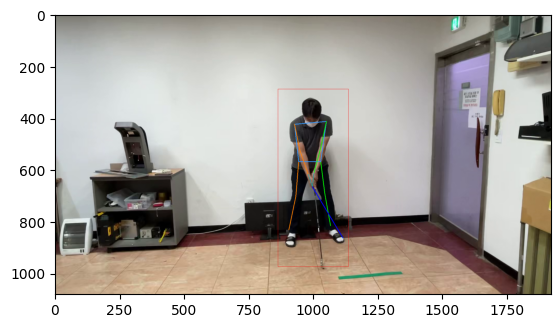

In [20]:

import matplotlib.pyplot as plt
plt.imshow(showFrame)